In [98]:
# Install python packages
!pip install -U torchtext==0.10.0 # torchtext https://pytorch.org/text/stable/index.html
!pip install konlpy # KoNLPy https://konlpy.org/ko/v0.6.0/
!pip install gensim # GENSIM https://radimrehurek.com/gensim/index.html#

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torchtext.legacy import data 
from torchtext.legacy.data import TabularDataset, Iterator
from torchtext.vocab import Vectors
from sklearn.model_selection import StratifiedKFold, train_test_split
from konlpy.tag import Okt
from google.colab import files
import csv
import urllib.request
from tqdm.notebook import tqdm
import gensim
from gensim.models import word2vec
from gensim.models.keyedvectors import KeyedVectors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [99]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.0005
EPOCHS = 75

In [115]:
# This is for debugging 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# CPU / GPU
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Device is:", DEVICE)

# Load dataset
train = pd.read_csv('https://raw.githubusercontent.com/EAexist/Detecting-Translated-Korean-Texts-Using-GRU/main/data/google/train.txt', sep='\t', header=0) # train set
test = pd.read_csv('https://raw.githubusercontent.com/EAexist/Detecting-Translated-Korean-Texts-Using-GRU/main/data/google/test.txt', sep='\t', header=0) # test set

tokenizer = Okt() # Konlpy's Okt tokneizer (twitter tokenizer of past)

# Build torchtext fields
TEXT = data.Field(sequential=True,
                  use_vocab=True,
                  tokenize=tokenizer.pos, # Use Konlpy Okt as a tokenizer
                  #lower=True,
                  batch_first=True,
                  fix_length=44)

LABEL = data.Field(sequential=False,
                   use_vocab=False,
                   is_target=True)

# 5-fold validation
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for i, (trn_idx,val_idx) in enumerate(skf.split(train['text'], train['translated'])):
    trn = train.iloc[trn_idx]
    val = train.iloc[val_idx]

trn.to_csv('trn.csv',index = False)
val.to_csv('val.csv',index = False)
test.to_csv('test.csv',index = False)

# Build Iterators for training
train_data, validation_data, test_data = TabularDataset.splits(
    path='', train='trn.csv',validation= 'val.csv', test='test.csv', format='csv', fields=[('label', LABEL), ('text', TEXT)], skip_header=True)

train_iter = Iterator(dataset = train_data, batch_size = BATCH_SIZE)
val_iter = Iterator(dataset = validation_data, batch_size = BATCH_SIZE)
test_iter = Iterator(dataset = test_data, batch_size = BATCH_SIZE,shuffle = False)

print('Training set size: {}'.format(len(train_data)))
print('Validation set size : {}'.format(len(validation_data)))
print('Test set size : {}'.format(len(test_data)))

print('Train data minibatch size : {}'.format(len(train_iter)))
print('Validation data minibatch size : {}'.format(len(val_iter)))
print('Test data minibatch size : {}'.format(len(test_iter)))


Device is: cuda
Training set size: 5376
Validation set size : 1344
Test set size : 1680
Train data minibatch size : 84
Validation data minibatch size : 21
Test data minibatch size : 27


In [104]:
# Word2vec Hyperparameters
W2V_SIZE = 100
W2V_MIN_COUNT = 2

# Load pre-built word vector
wv = KeyedVectors.load('https://raw.githubusercontent.com/EAexist/Detecting-Translated-Korean-Texts-Using-GRU/main/data/google/pos_korean_translation.vec', mmap='r') 
# wv = w2v_model.wv

TEXT.build_vocab(train_data,
                 min_freq = W2V_MIN_COUNT, 
                 max_size = 20000,
                 )
word2vec_vectors = []
total = 0
counter = 0

for token, idx in tqdm(TEXT.vocab.stoi.items()):
    total += 1
    token = '(\'' + '\',\''.join(token) + '\')'
    if total < 20 :
      print(type(token), token)
    if token in list(wv.vocab.keys()):
        word2vec_vectors.append(torch.FloatTensor(wv[token]))        
    else:
        word2vec_vectors.append(torch.zeros(W2V_SIZE))
        counter += 1

TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, W2V_SIZE)
pre_trained_emb = torch.FloatTensor(TEXT.vocab.vectors)

print('Vocab size : {}'.format(len(TEXT.vocab)))
print(counter, '/', total)

  0%|          | 0/11594 [00:00<?, ?it/s]

<class 'str'> ('<','u','n','k','>')
<class 'str'> ('<','p','a','d','>')
<class 'str'> ('을','Josa')
<class 'str'> ('.','Punctuation')
<class 'str'> ('이','Josa')
<class 'str'> ('에','Josa')
<class 'str'> ('의','Josa')
<class 'str'> ('"','Punctuation')
<class 'str'> ('를','Josa')
<class 'str'> (',','Punctuation')
<class 'str'> ('은','Josa')
<class 'str'> ('했다','Verb')
<class 'str'> ('가','Josa')
<class 'str'> ('는','Josa')
<class 'str'> ('."','Punctuation')
<class 'str'> ('으로','Josa')
<class 'str'> ('에서','Josa')
<class 'str'> ('한','Josa')
<class 'str'> ('(','Punctuation')
Vocab size : 11594
2081 / 11594


In [105]:
vocab_size = len(TEXT.vocab)
n_classes = 2 

# GRU Model

This is GRU-based model for translated(machine-generated) Korean sentence detection.\
GRU-2 consists of 2 linear + dropout layers.\
GRU-3 consists of 3 linear + dropout layers.\

1. Use of pre-trained embedding layer : Block/unblock the codes in part named "Embedding Mode"
2. GRU-2 / GRU-3 : Block/unblock the codes in part named "GRU-2 / GRU-3"


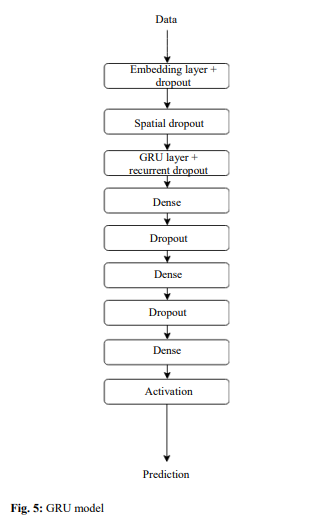


In [112]:
# Blocks
class DenseBlock(nn.Module):
    def __init__(self, in_dim, out_dim, softmax = False):
      super(DenseBlock, self).__init__()
      self.dense = nn.Linear(in_dim, out_dim) # dense layer
      self.act = nn.Softmax(dim=1) if softmax else nn.ReLU() # activation function

    def forward(self, x):
      x =  self.dense(x)
      out = self.act(x)
      return out

# Model
class Detector(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(Detector, self).__init__()
        print("Building Detector...")
        self.n_layers = n_layers 
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(dropout_p)

        ######################################################################################
        #### Embedding Modes : Unblock one of the follwing two lines and block the other. ####
        ######################################################################################
        #self.embed = nn.Embedding(n_vocab, embed_dim) # without pre-trained word2vec           
        self.embed = nn.Embedding.from_pretrained(pre_trained_emb) # with pre-trained word2vec
        ######################################################################################

        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers = self.n_layers,
                          batch_first = True)
        self.dense = DenseBlock(self.hidden_dim, self.hidden_dim)
        self.out = DenseBlock(self.hidden_dim, n_classes, True)

    def forward(self, x):
        
        # Embedding layer
        x = self.dropout(self.embed(x))      
  
        # GRU layer
        h_0 = self._init_state(batch_size=x.size(0)) # Initialize hidden vector as zero vector
        x, _ = self.gru(x, h_0)  # x : (batch_size, input length, hidden_dim)
        x = x[:,-1,:] # x : (batch_size, 1, hidden_dim), last hidden state in each batch
        x = self.dropout(x) 

        # Linear layers 
        x = self.dropout(self.dense(x))
        x = self.dropout(self.dense(x))

        ######################################################################################
        #### GRU-2 / GRU-3 : Block the follwing line to make GRU-2, unblock to make GRU-3 ####
        ######################################################################################
        # x = self.dropout(self.dense(x)) # Block: GRU-2(2 linear layers). Unblock : GRU-3(3 linear layers)
        #######################################################################################

        # Output layer
        logit = self.out(x) # ((batch_size, hidden_dim) -> (batch_size, out_dim)
        return logit
    
    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

def train(model, optimizer, train_iter):
    model.train()

    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        optimizer.zero_grad() 
        logit = model(x) # Predicted logit
        loss = F.cross_entropy(logit, y) # Cross entropy
        loss.backward()
        optimizer.step()

def evaluate(model, val_iter):    
    model.eval()
    corrects, total_loss = 0, 0

    for batch in val_iter: 
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        logit = model(x) # Predicted logit
        loss = F.cross_entropy(logit, y, reduction='sum') # Cross entropy
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size

    return avg_loss, avg_accuracy

In [113]:
# Model Structure
PRE = ''
# PRE = '_pre'
NUM_LINEAR = '3'
# NUM_LINEAR = '_2' 

# Model Hyperparameter
EMB_DIM = 100
HIDDEN_DIM = 256
DROPOUT = 0.5

for EMB_DIM in [200]:

  model = Detector(5, HIDDEN_DIM, vocab_size, EMB_DIM, n_classes, DROPOUT).to(DEVICE)
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  best_val_loss = None
  best_epoch = 0

  title = 'result%s%s_hid%d_emb%d.txt' % (PRE, NUM_LINEAR, HIDDEN_DIM, EMB_DIM)

  with open(title,'w', encoding='utf-8') as fp:
    fp.write("Title\n")
    for e in range(1, EPOCHS+1):
        train(model, optimizer, train_iter)
        val_loss, val_accuracy = evaluate(model, val_iter)
        test_loss, test_acc = evaluate(model, test_iter)

        print("[Epoch: %d] Val. loss:%5.2f | Val. acc:%5.2f" % (e, val_loss, val_accuracy))
        print('Test loss: %5.2f | Tess acc: %5.2f' % (test_loss, test_acc))
        fp.write("%d, %5.2f, %5.2f,\n" % (e, val_loss, val_accuracy))

        # Save best model with least validation loss
        if not best_val_loss or val_loss < best_val_loss:
            if not os.path.isdir("snapshot"):
                os.makedirs("snapshot")
            torch.save(model.state_dict(), './snapshot/txtclassification.pt')
            best_epoch = e
            best_val_loss = val_loss

    model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
    test_loss, test_acc = evaluate(model, test_iter)

    print('[Best model] Epoch: %d \n Test loss: %5.2f | Test acc: %5.2f' % (best_epoch, test_loss, test_acc))
    fp.write("%d, %5.2f, %5.2f,\n" % (best_epoch, test_loss, test_acc))

  files.download(title)

Building Detector...
[Epoch: 1] Val. loss: 0.67 | Val. acc:59.38
Test loss:  0.67 | Tess acc: 59.88
[Epoch: 2] Val. loss: 0.65 | Val. acc:62.13
Test loss:  0.64 | Tess acc: 63.45
[Epoch: 3] Val. loss: 0.65 | Val. acc:62.65
Test loss:  0.64 | Tess acc: 63.93
[Epoch: 4] Val. loss: 0.65 | Val. acc:62.05
Test loss:  0.64 | Tess acc: 63.33
[Epoch: 5] Val. loss: 0.65 | Val. acc:62.43
Test loss:  0.64 | Tess acc: 63.57
[Epoch: 6] Val. loss: 0.65 | Val. acc:62.72
Test loss:  0.64 | Tess acc: 63.81
[Epoch: 7] Val. loss: 0.65 | Val. acc:63.02
Test loss:  0.64 | Tess acc: 64.17
[Epoch: 8] Val. loss: 0.65 | Val. acc:61.98
Test loss:  0.64 | Tess acc: 65.12
[Epoch: 9] Val. loss: 0.65 | Val. acc:62.13
Test loss:  0.64 | Tess acc: 64.23
[Epoch: 10] Val. loss: 0.64 | Val. acc:62.80
Test loss:  0.63 | Tess acc: 64.23
[Epoch: 11] Val. loss: 0.65 | Val. acc:62.28
Test loss:  0.64 | Tess acc: 64.64
[Epoch: 12] Val. loss: 0.65 | Val. acc:61.83
Test loss:  0.64 | Tess acc: 65.00
[Epoch: 13] Val. loss: 0.65 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [97]:
files.download('result_2_hid256_emb200.txt')
files.download('result_2_hid256_emb300.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#References

Dataset 
1. National Information Society Agency, AI Hub \
https://aihub.or.kr/aidata/87

Tokenizer 

2. KoNLPy \
https://konlpy.org/ko/v0.6.0/api/konlpy.tag/

Word2vec API

3. Radim Řehůřek, GENSIM API Reference - models.word2vec \
https://radimrehurek.com/gensim/models/word2vec.html

Model Design

4. Basyar, Iqbal & Adiwijaya, Kang & Murdiansyah, Danang. (2020). Email Spam Classification Using Gated Recurrent Unit and Long Short-Term Memory. Journal of Computer Science. 16. 559-567. 10.3844/jcssp.2020.559.567. \
https://thescipub.com/pdf/jcssp.2020.559.567.pdf 


Training and Evaluation
5. https://ariz1623.tistory.com/303 
6. https://github.com/yellowjs0304/3-min-pytorch_study/blob/master/07-%EC%88%9C%EC%B0%A8%EC%A0%81%EC%9D%B8_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC_%EC%B2%98%EB%A6%AC%ED%95%98%EB%8A%94_RNN/text_classification.ipynb




In [48]:
def split_df(df):
  df = df.sample(frac=1, random_state=0)
  df = df.reset_index(drop=True)
  size = len(df.index)
  split_id = int(size * 0.8)
  print(size, split_id)
  train = df.iloc[:split_id,:]
  test = df.iloc[split_id:,:]
  return train, test

df = pd. DataFrame([], columns = ['translated', 'text'])

df_data = pd.read_csv('/content/drive/MyDrive/Detecting-Translated-Korean-Texts-Using-GRU/data/google/data.txt', sep='\t', header=0)

columns_titles = ['text','translated']
df_data = df_data.reindex(columns=columns_titles)

df_0 = df_data[df_data['translated']==0]
df_1 = df_data[df_data['translated']==1]

print(len(df_data), len(df_0), len(df_1))

train0, test0 = split_df(df_0)
train1, test1 = split_df(df_1)

print(test0)

train = pd.concat([train0, train1])
test = pd.concat([test0, test1])

train['text'] = train['text'].apply(lambda x: x.strip())
test['text'] = test['text'].apply(lambda x: x.strip())

train.to_csv('train.txt', index=False, sep="\t")

test.to_csv('test.txt', index=False, sep="\t")

files.download('train.txt')
files.download('test.txt')

8400 4200 4200
4200 3360
4200 3360
                                                   text  translated
3360  제주도농업기술원 서귀포농업기술센터는 ‘탄소 없는 섬 제주’ 실현에 기여하고 농가 경...           0
3361  여성가족부는 지난해 11월 이후 수립된 성희롱·성폭력 근절대책속 지침 및 법률개정 ...           0
3362  오는 7월 시행을 목표로 한 시내버스 노선개편은 현재 200대인 시내버스를 70대 ...           0
3363  스스로를 ‘스페셜 원’으로 칭하며 권위와 카리스마를 강조하는 무리뉴 감독의 스타일에...           0
3364  "이 회장은 “국가적 재난 상황이며, 구단들도 주말경기 불꽃행사까지 취소한 상황에서...           0
...                                                 ...         ...
4195  청와대 윤종원 경제수석은 전날 한 포럼에서 ‘기업하기 좋은 나라’를 만드는 것과 함...           0
4196  이에 나 원내대표는 10일 기자간담회에서 “일부 의원들의 발언이 5·18 희생자들에...           0
4197  이른 시간 내에 앞선다면 벤투호가 자랑하는 후방 빌드업을 시작으로 시나리오대로 손쉽...           0
4198  지난 2일 폐막한 아시안 게임의 여운이 계속되고 있는 가운데 국내 최대 체육행사로 ...           0
4199  지방선거와 같은 날 전국적으로 실시되는 연급 수급연령 상향 반대 시위에 국민의 참여...           0

[840 rows x 2 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [116]:
# Word2vec Hyperparameters
W2V_SIZE = 100
W2V_MIN_COUNT = 2

# Convert train data dataframe into list for preprocessing
train_sentence_list = train['text'].tolist()
print(train_sentence_list[:5])

print_count = 5
print_counter = 0

# Tokenize train data to build word2vec vector 
token_string_list = []

for line in train_sentence_list:

    # Proper sentences are in type string. Discard the others.
    if not isinstance(line, str):
      continue

    # Tokenize each sentence(=line) with Okt().pos. token is tuple of strings (morpheme, pos tag) e.g. ('는', 'Josa') 
    token_list = tokenizer.pos(line, norm=True, stem=True)
    r = []

    for token in token_list:

      # # Do not process 조사(Josa), 어미(Eomi), Punctuation 
      # if not token[1] in ["Josa","Eomi","Punctuation"]:
      #     r.append('(\'' + '\',\''.join(token) + '\')')
      r.append('(\'' + '\',\''.join(token) + '\')')

    token_string_list += r

    # Print result print_count times
    if print_counter < print_count:
      print(r)
    print_counter += 1

# Load pre-trained word2vc Korean morpheme vectors. 
# #### This may take several minutes due to large file size (96.1MB) ####
pretrained_vectors_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Detecting-Translated-Korean-Texts-Using-GRU/data/pos.vec', binary=False)
pretrained_vectors_model.save('pos_vec')

# w2v_model.build_vocab([list(pretrained_vectors_model.vocab.keys())], update = True)
# w2v_model.intersect_word2vec_format('pos.vec', binary=False)

# Build new word2vec model
w2v_model = word2vec.Word2Vec(size=W2V_SIZE, window=10, hs=1, min_count=W2V_MIN_COUNT, sg=1)

# print(list(pretrained_vectors_model.vocab.keys())[:5])
# print(token_string_list[:5])

w2v_model.build_vocab([token_string_list])

# print(w2v_model.wv.vocab.keys())

total_examples = w2v_model.corpus_count
w2v_model.build_vocab([list(pretrained_vectors_model.vocab.keys())], update = True)
w2v_model.intersect_word2vec_format('/content/drive/MyDrive/Detecting-Translated-Korean-Texts-Using-GRU/data/pos.vec', binary=False)
w2v_model.train(token_string_list, total_examples=total_examples, epochs=w2v_model.iter)

w2v_model.wv.save('pos_korean_translation.vec')
files.download('pos_korean_translation.vec')

# Save token list as a file
with open('token_list.txt','w', encoding='utf-8') as fp:
    fp.write("\n".join(token_string_list))

files.download('token_list.txt')

['이 연구원은 “장기성장성을 지지하던 이슈가 없어졌을 뿐만 아니라 향후 해외 훈련기 시장에서의 수주경쟁력에 장애 요인이 생겼다”며 “한국항공우주의 목표주가를 22.2% 내린 3만5000원으로 하향한다”고 평가했다.', '장타를 강점으로 내세우는 코엡카는 대회 시작 전 “아무리 바람이 불어도 볼 스트라이킹이 좋다면 우승할 수 있다”고 자신한 바 있다.', '이 중 현재 임명 절차가 진행되고 있는 충남연구원장은 공석 기간 장기화 우려에 따라 이번에는 실시하지 않기로 합의했다.', '"이날 코스피 지수는 전 거래일보다 26.08포인트 (-1.10%) 하락한 2,337.83으로, 코스닥 지수는 전 거래일보다 13.95포인트(-1.66) 하락한 826.22로 장을 마감했다."', '축제추진위원회는 행사 기간 관광객들이 편안하고 안전하게 추자도를 방문할 수 있도록 제주∼추자 항로의 정기 여객선인 ‘퀸스타2호’ 운항 횟수를 늘릴 방침이다.']
["('이','Noun')", "('연구원','Noun')", "('은','Josa')", "('“','Foreign')", "('장기','Noun')", "('성장','Noun')", "('성','Suffix')", "('을','Josa')", "('지지','Noun')", "('하다','Verb')", "('이슈','Noun')", "('가','Josa')", "('없어지다','Verb')", "('뿐','Noun')", "('만','Josa')", "('아니다','Adjective')", "('향후','Noun')", "('해외','Noun')", "('훈련기','Noun')", "('시장','Noun')", "('에서의','Josa')", "('수','Modifier')", "('주','Modifier')", "('경쟁력','Noun')", "('에','Josa')", "('장애','Noun')", "('요인','Noun')", "('이','Josa')", "('생기다','Verb')", "('”','Foreign')", "

ValueError: ignored

In [ ]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('Test loss: %5.2f | Tess acc: %5.2f' % (test_loss, test_acc))

In [ ]:
# #### Garbage ####

# import os
# from torchtext.legacy import data, datasets
# # 데이터 로딩하기
# print("데이터 로딩중...")

# # data.Field 설명 #
# # sequential인자 : TEXT는 Sequential 데이터라 True, Lable은 비Sequential이라 False로 설정
# # batch_first : Batch를 우선시 하여, Tensor 크기를 (BATCH_SIZE, 문장의 최대 길이)로 설정
# # lower : 소문자 전환 인자
# # # # # # # # # # #
# TEXT = data.Field(sequential=True, batch_first=True, lower=True)
# LABEL = data.Field(sequential=False, batch_first=True)

# #IMDB 데이터 로딩
# trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

# # data.Field.build_vocab() 라이브러리
# # 문장 내 단어와 Integer index 를 매칭시키는 단어장(vocab)을 생성 == 워드 임베딩을 위한 Vocab 생성
# # <UNK> = 0, <PAD> = 1 토큰도 추가.
# # min_freq : 최소 5번 이상 등장한 단어들만 사전에 담겠다는 것. 
# # 5번 미만으로 등장하는 단어는 UNK라는 토큰으로 대체
# TEXT.build_vocab(trainset, min_freq=5)# TEXT 데이터를 기반으로 Vocab 생성
# LABEL.build_vocab(trainset)# LABEL 데이터를 기반으로 Vocab 생성


# # 학습용 데이터를 학습셋 80% 검증셋 20% 로 나누기
# trainset, valset = trainset.split(split_ratio=0.8)
# # 매 배치마다 비슷한 길이에 맞춰 줄 수 있도록 iterator 정의
# train_iter, val_iter, test_iter = data.BucketIterator.splits(
#         (trainset, valset, testset), batch_size=BATCH_SIZE,
#         shuffle=True, repeat=False)


# vocab_size = len(TEXT.vocab)
# n_classes = 2 
# # Positive, Negative Class가 두 개

# '''
# # Test #
# for batch in train_iter:
#     print(batch.text)
#     print(batch.label)
#     break
# '''     

# print("[학습셋]: %d [검증셋]: %d [테스트셋]: %d [단어수]: %d [클래스] %d"
#       % (len(trainset),len(valset), len(testset), vocab_size, n_classes))


# General corpus : Naver Movie sentiment corpus
# urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
# corpus_general = pd.DataFrame(pd.read_table('ratings.txt')['document']).dropna(how = 'any')
# corpus_general.columns = ['text']
# corpus_general['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# # Target corpus : target sentences
# corpus_target = pd.DataFrame(pd.concat([train, test])['text'])
# print(corpus_general[:5], corpus_target[:5])

# # Merge general corpus with target corpus
# corpus = pd.concat([corpus_general, corpus_target])
# print(corpus[:5])

In [ ]:
df = pd. DataFrame([], columns = ['translated', 'text'])

with open('google.txt','r', encoding='utf-8') as rp:
  for line in rp:
    line_list = line.strip().split('\t')
    if 'text' in line_list : continue
    df_length = len(df)
    df.loc[df_length] = line_list
print(df[:5])
df.to_csv('data.txt',sep='\t', index = False)

files.download('data.txt')

In [16]:
# train_data, validation_data, test_data = TabularDataset.splits(
#      path='', train='trn.csv',validation= 'val.csv', test='test.csv', format='csv',
#         fields=[('text', TEXT), ('label', LABEL)], skip_header=True)

# print('훈련 샘플의 개수 : {}'.format(len(train_data)))
# print('검증 샘플의 개수 : {}'.format(len(validation_data)))
# print('테스트 샘플의 개수 : {}'.format(len(test_data)))

# TEXT.build_vocab(train_data,
#                  min_freq = W2V_MIN_COUNT, 
#                  max_size = 20000,
#                  vector = vectors
#                  )

# word2vec_vectors = []
# total = 0
# counter = 0

# for token, idx in tqdm(TEXT.vocab.stoi.items()):
#     total += 1
#     if token in wModel.wv.vocab.keys():
#         word2vec_vectors.append(torch.FloatTensor(wModel[token]))
#     else:
#         word2vec_vectors.append(torch.zeros(W2V_SIZE))
#         counter += 1

# TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, W2V_SIZE)
# pre_trained_emb = torch.FloatTensor(TEXT.vocab.vectors)

# print('단어 집합의 크기 : {}'.format(len(TEXT.vocab)))

# train_iter = Iterator(dataset = train_data, batch_size = BATCH_SIZE)
# val_iter = Iterator(dataset = validation_data, batch_size = BATCH_SIZE)
# test_iter = Iterator(dataset = test_data, batch_size = BATCH_SIZE,shuffle = False)

# print('훈련 데이터의 미니 배치 수 : {}'.format(len(train_iter)))
# print('검증 데이터의 미니 배치 수 : {}'.format(len(val_iter)))
# print('테스트 데이터의 미니 배치 수 : {}'.format(len(test_iter)))

# print(counter, '/', total)